Authors: Cynarski Michał & Barszczak Barłomiej
AGH WEAIiIB AIR-ISZ

# Bayesian models for predicting the number of fatalities in terrorist attacks using GTD data.

#### Libraries import

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

SEED = 123
SAMPLES_SIZE = 1000

MODEL_PATH_1 = "new_code1.stan"
MODEL_PATH_1_PPC = "new_code1_ppc.stan"

MODEL_PATH_2 = "new_code2.stan"
MODEL_PATH_2_PPC = "new_code2_ppc.stan"

In [2]:
def scatter_hist_display(val_mat, y_values):
    fig, axs = plt.subplots(2, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5*len(val_mat.columns), 10)

    for i, col in enumerate(val_mat.columns):
        axs[0, i].scatter(val_mat[col], y_values)
        axs[0, i].set_title(col)
        axs[0, i].set_ylabel(y_values.name)
        axs[0, i].grid()

        axs[1, i].hist(val_mat[col])
        axs[1, i].set_ylabel("Density")
        axs[1, i].set_xlabel(col)
        axs[1, i].grid()

def hist_compare(y_real, y_gen):
    plt.figure(dpi=150)
    max_val = int(max(y_real.max(), y_gen.max())) + 1
    bins = range(0, max_val + 1)
    y_real.hist(alpha=0.5, label="Real", bins=bins)
    y_gen.hist(alpha=0.5, label="Generated", bins=bins)
    plt.legend()
    plt.title("Generated samples")
    plt.xlabel(y_real.name)
    plt.xlim(0,20)
    plt.grid()
    plt.show()


def scatter_compare_display(val_mat, y_values_orig, y_values_gen):
    fig, axs = plt.subplots(1, len(val_mat.columns), dpi=300)
    fig.set_size_inches(5 * len(val_mat.columns), 5)

    for i, col in enumerate(val_mat.columns):
        #print(f"Length x (val_mat[col]): {len(val_mat[col])}")
        #print(f"Length y (y_values_gen): {len(y_values_gen)}")
        axs[i].scatter(val_mat[col], y_values_orig, alpha=0.8, label="Original")
        axs[i].scatter(val_mat[col], y_values_gen, alpha=0.8, label="Generated")
        axs[i].set_title(col)
        axs[i].set_ylabel(y_values_orig.name)
        axs[i].set_xlabel(col)
        axs[i].grid()
        axs[i].legend()

## 1. Prolem formulation

# TODO

## 2. Data preprocessing

In [3]:
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding='latin-1', low_memory=False)

categorical_columns = ['weaptype1_txt', 'targtype1_txt', 'country_txt']
predictors = categorical_columns + ['nperps']

selected_columns = ['nkill'] + predictors
df = df[selected_columns].dropna()
print(len(df), "rows in the dataset before filtering")

df = df[df['nperps'] > 0 ]
df = df[df['nperps'] < 1000 ]
print(len(df), "rows in the dataset after filtering nperps > 0")

df = df.sample(n=SAMPLES_SIZE, random_state=SEED)
print(len(df), "rows in the dataset after filtering")
df.head()


for column in categorical_columns:
    le = LabelEncoder()
    df[column.replace("txt", "encoded")] = le.fit_transform(df[column]) + 1


selected_columns = ["weaptype1_encoded", "targtype1_encoded", "country_encoded", "nperps"]
df_data = df[selected_columns]

weaptype1 = df['weaptype1_encoded'].values
targtype1 = df['targtype1_encoded'].values
country = df['country_encoded'].values
X_cont = df['nperps']
X_cont = ((X_cont - X_cont.mean()) / X_cont.std()).values
nkill = df['nkill'].values

df2 = df[['nkill', 'weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']]


stan_data_pcc = {
        'N': len(df),
        'K_cont': 1,
        'K_weaptype': int(weaptype1.max()),
        'K_targtype': int(targtype1.max()),
        'K_country': int(country.max()),
        'X_cont': X_cont.reshape(-1, 1),
        'weaptype': weaptype1.tolist(),
        'targtype': targtype1.tolist(),
        'country': country.tolist()
}

stan_data = {
        'N': len(df),
        'K_cont': 1,                         # 1 since we got only 1 column
        'K_weaptype': int(weaptype1.max()),  # number of weapon types
        'K_targtype': int(targtype1.max()),  # number of target types
        'K_country': int(country.max()),     # number of countries
        'X_cont': X_cont.reshape(-1, 1),
        'weaptype': weaptype1.tolist(),
        'targtype': targtype1.tolist(),
        'country': country.tolist(),
        'nkill': np.array(nkill, dtype=int).tolist()
}

106122 rows in the dataset before filtering
27272 rows in the dataset after filtering nperps > 0
1000 rows in the dataset after filtering


## 3. Model

# TODO

## 4. Priors

#### Model 1

In [4]:
model1_ppc = CmdStanModel(stan_file=MODEL_PATH_1_PPC)
sim1_ppc = model1_ppc.sample(
    data=stan_data_pcc,
    seed=SEED,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000
)

df_1_ppc = sim1_ppc.draws_pd()
offset = 10 + 1 + 1 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
data = df_1_ppc.iloc[0][offset:SAMPLES_SIZE+offset]

21:06:19 - cmdstanpy - INFO - compiling stan file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code1_ppc.stan to exe file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code1_ppc
21:06:29 - cmdstanpy - INFO - compiled model executable: /workspace/Project/Data-Analitics-Project/IdeaV2/new_code1_ppc
21:06:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:29 - cmdstanpy - INFO - CmdStan done processing.
21:06:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_log_rng: Log rate parameter is 24.285, but must be less than 20.794415 (in 'new_code1_ppc.stan', line 63, column 4 to column 63)
Exception: poisson_log_rng: Log rate parameter is 23.5114, but must be less than 20.794415 (in 'new_code1_ppc.stan', line 63, column 4 to column 63)
	Exception: poisson_log_rng: Log rate parameter is 21.1628, but must be less than 20.794415 (in 'new_code1_ppc.stan', line 63, column 4 to column 63)
	Exception: poisson_log_rng: Log rate parameter is 21.2089, but must be less than 20.794415 (in 'new_code1_ppc.stan', line 63, column 4 to column 63)
	Exception: poisson_log_rng: Log rate parameter is 27.0739, but must be less than 20.794415 (in 'new_code1_ppc.stan', line 63, column 4 to column 63)
Exception: poisson_log_rng: Log rate parameter is 20.8879, but must be less than 20.794415 (in 'new_code1_ppc.stan', line 63, column

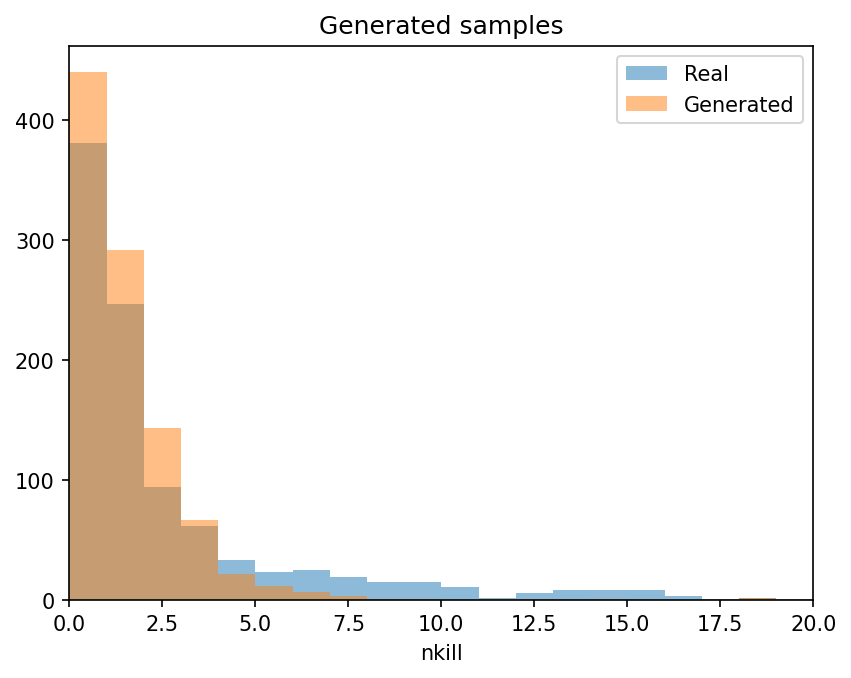

In [5]:
hist_compare(df2['nkill'], data)

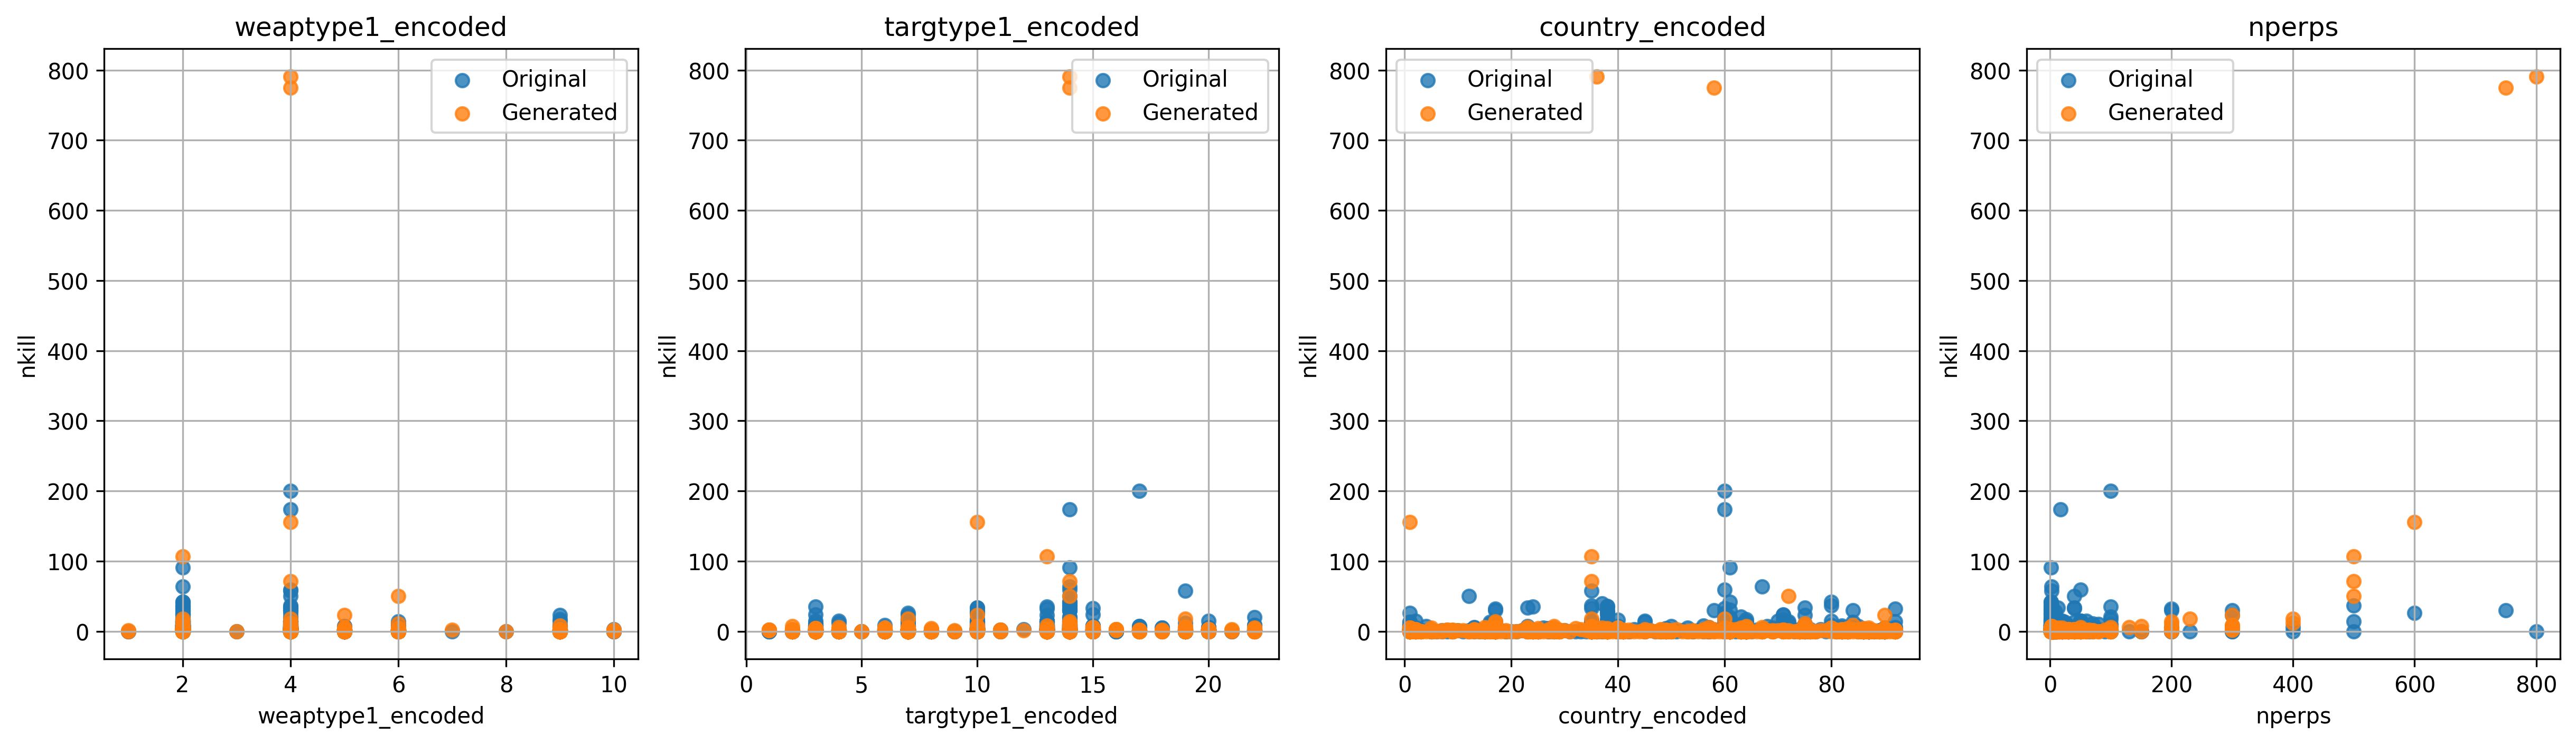

In [6]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

#### Model 2

In [7]:
model2_ppc = CmdStanModel(stan_file=MODEL_PATH_2_PPC)
sim2_ppc = model2_ppc.sample(
    data=stan_data_pcc,
    seed=SEED,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000
)

offset = 10 + 1 + 2 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
df_2_ppc = sim2_ppc.draws_pd()
data = df_2_ppc.iloc[0][offset:SAMPLES_SIZE+offset]

21:06:34 - cmdstanpy - INFO - compiling stan file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code2_ppc.stan to exe file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code2_ppc
21:06:44 - cmdstanpy - INFO - compiled model executable: /workspace/Project/Data-Analitics-Project/IdeaV2/new_code2_ppc
21:06:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:45 - cmdstanpy - INFO - CmdStan done processing.
21:06:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 3.12901e+09, but must be less than 1073741824.000000 (in 'new_code2_ppc.stan', line 66, column 4 to column 75)
	Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 1.51934e+09, but must be less than 1073741824.000000 (in 'new_code2_ppc.stan', line 66, column 4 to column 75)
Exception: neg_binomial_2_log_rng: Random number that came from gamma distribution is 4.84755e+09, but must be less than 1073741824.000000 (in 'new_code2_ppc.stan', line 66, column 4 to column 75)
Consider re-running with show_console=True if the above output is unclear!


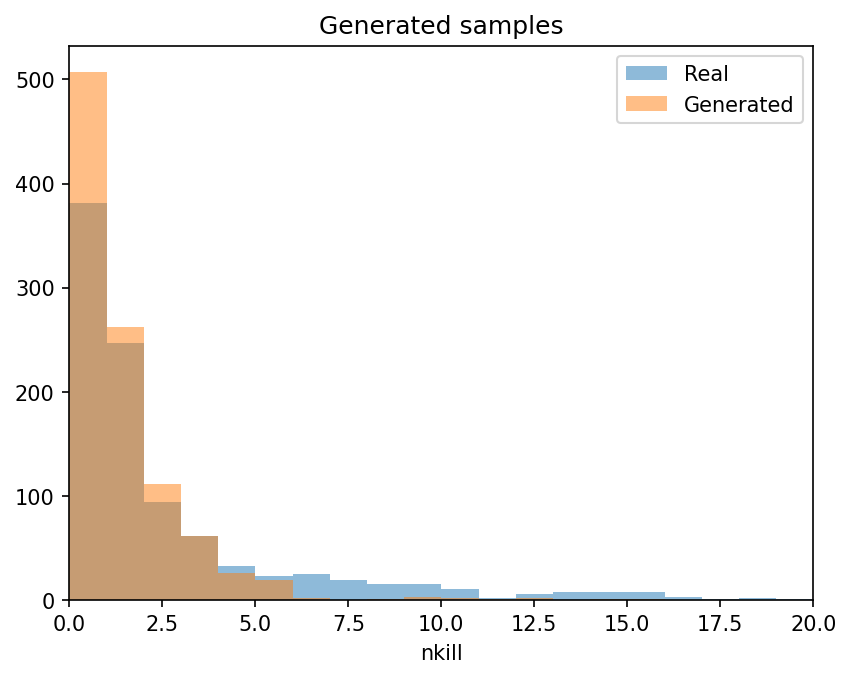

In [8]:
hist_compare(df2['nkill'], data)

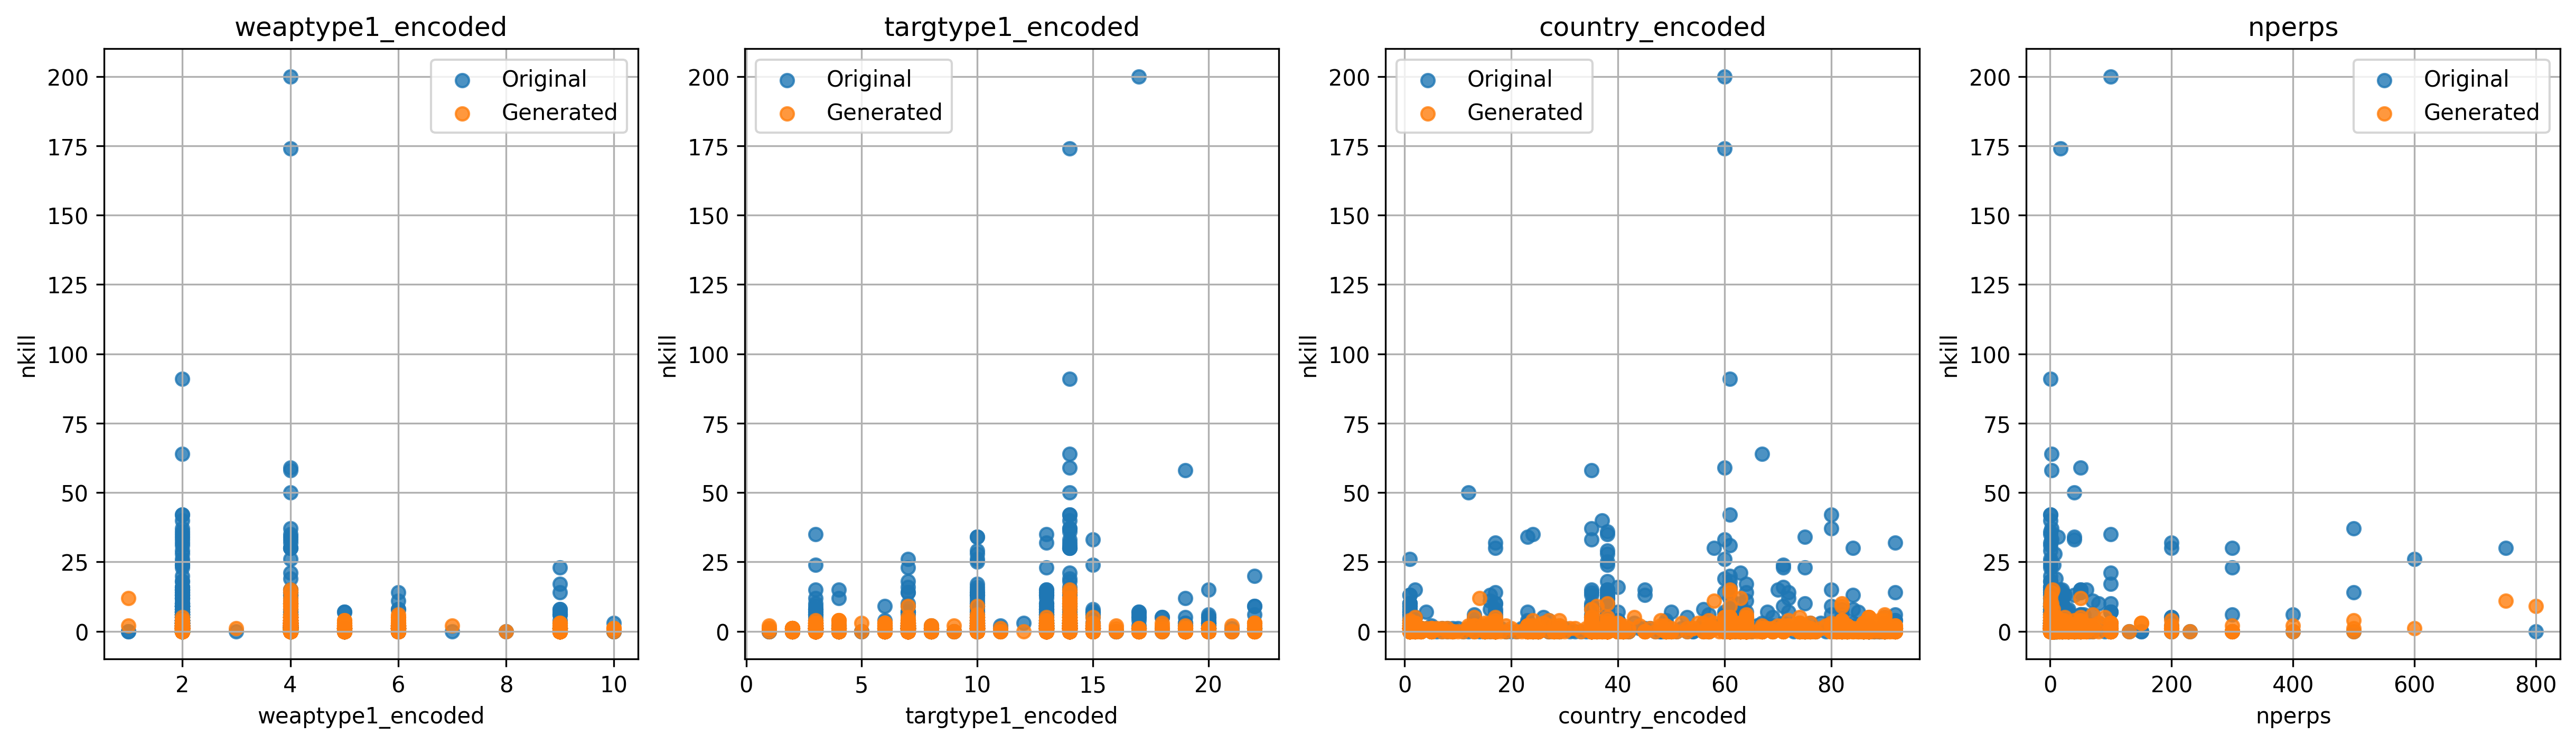

In [9]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

## 5. Posterior analysis (model 1)

In [10]:
model1 = CmdStanModel(stan_file=MODEL_PATH_1)

sim1 = model1.sample(
    data=stan_data,
    seed=SEED,
    chains=4,
    iter_sampling=4000,
    iter_warmup=1000
)

df_1 = sim1.draws_pd()
offset = 10 + 1 + 1 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
data = df_1.iloc[0][offset:SAMPLES_SIZE+offset]

21:06:49 - cmdstanpy - INFO - compiling stan file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code1.stan to exe file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code1
21:07:03 - cmdstanpy - INFO - compiled model executable: /workspace/Project/Data-Analitics-Project/IdeaV2/new_code1
21:07:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:34 - cmdstanpy - INFO - CmdStan done processing.


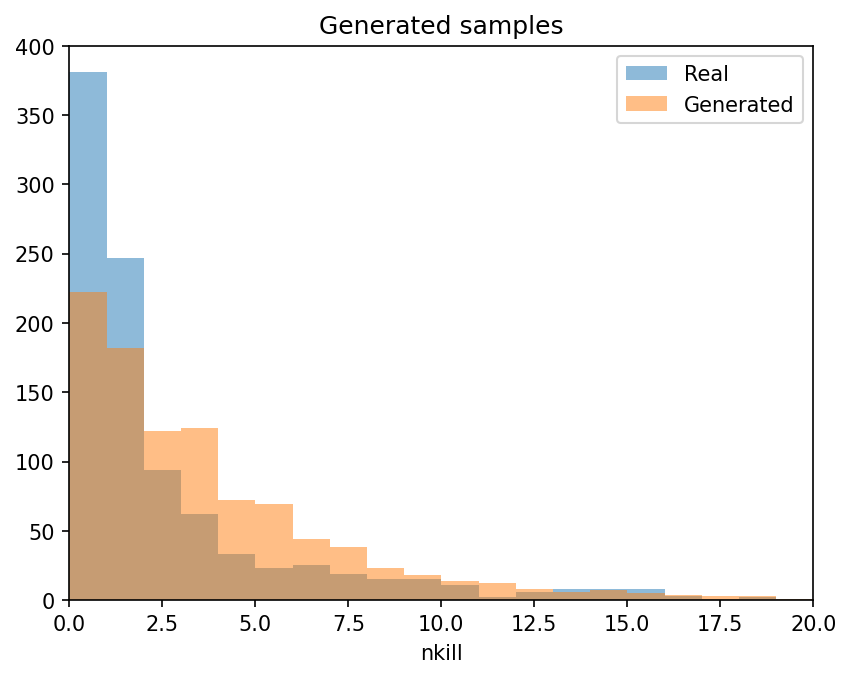

In [11]:
hist_compare(df2['nkill'], data)

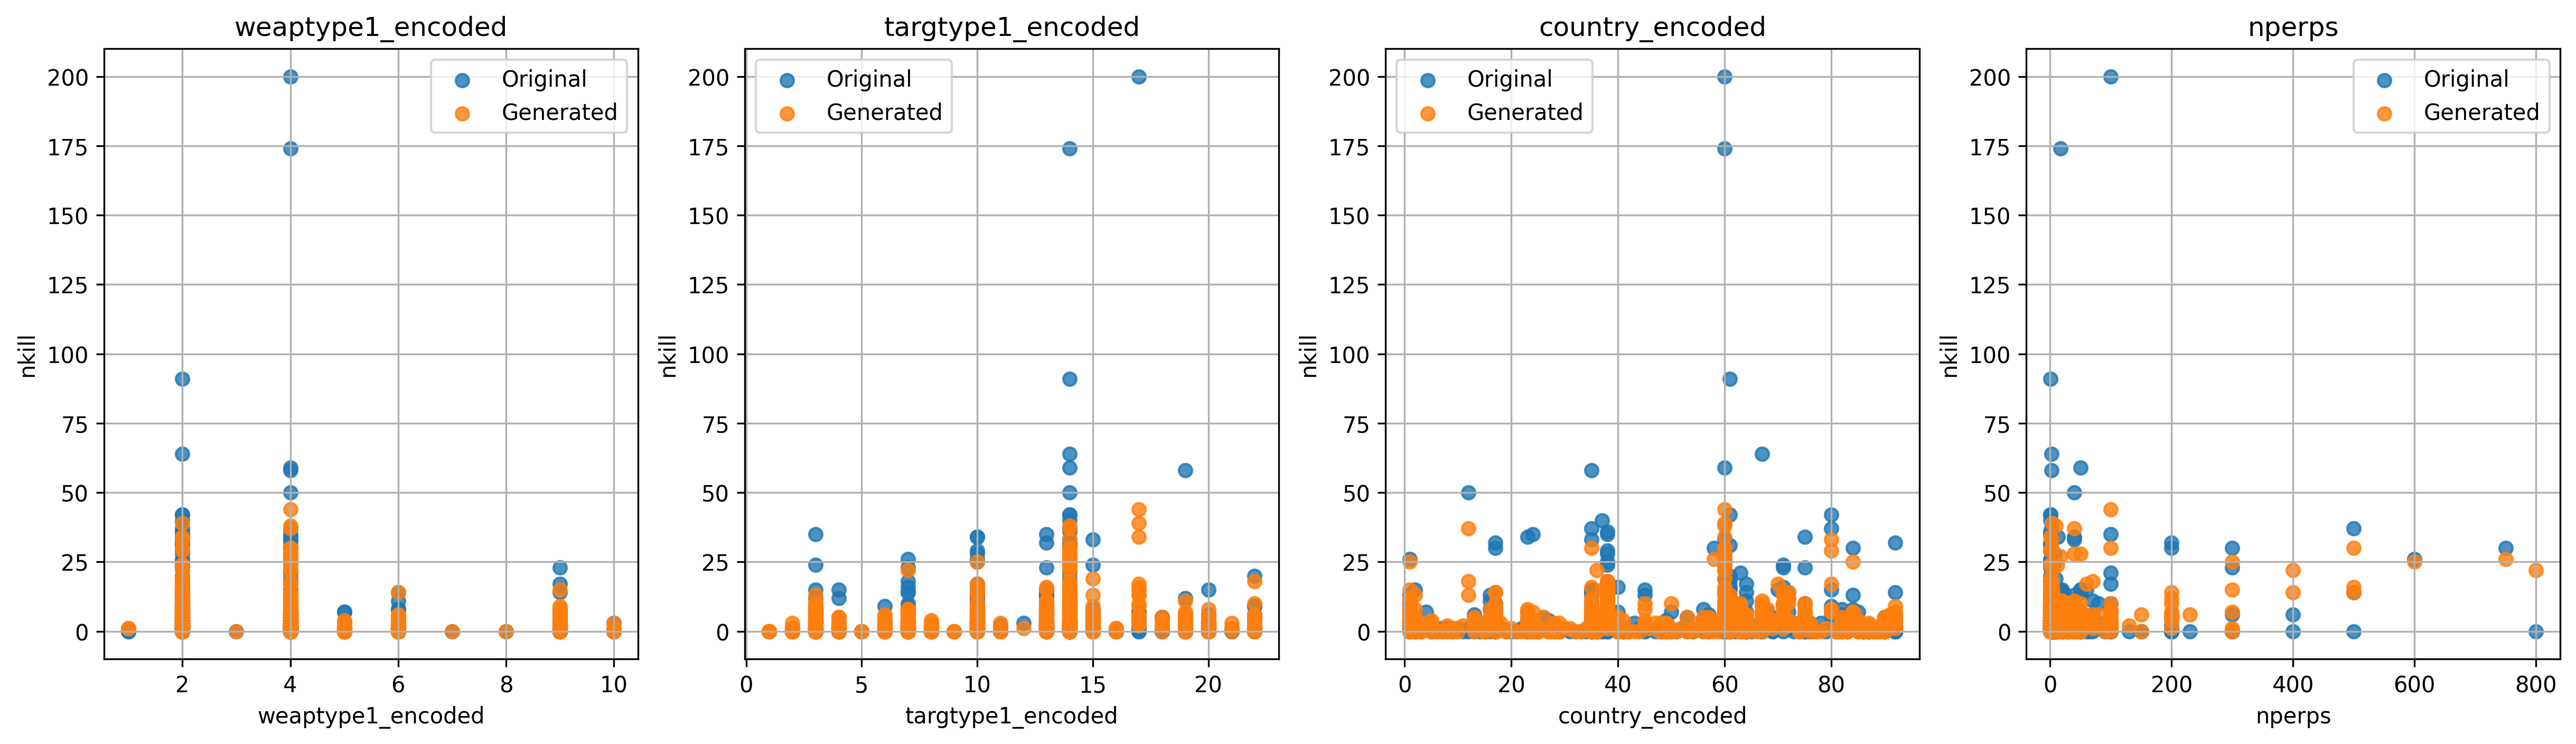

In [12]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

## 6. Posterior analysis (model 2)

In [13]:
model2 = CmdStanModel(stan_file=MODEL_PATH_2)

sim2 = model2.sample(
    data=stan_data,
    seed=SEED,
    chains=4,
    iter_sampling=4000,
    iter_warmup=1000
)

df_2 = sim2.draws_pd()
offset = 10 + 1 + 2 + int(weaptype1.max()) + int(targtype1.max()) + int(country.max())
data = df_2.iloc[0][offset:SAMPLES_SIZE+offset]

21:07:42 - cmdstanpy - INFO - compiling stan file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code2.stan to exe file /workspace/Project/Data-Analitics-Project/IdeaV2/new_code2
21:07:57 - cmdstanpy - INFO - compiled model executable: /workspace/Project/Data-Analitics-Project/IdeaV2/new_code2
21:07:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:25 - cmdstanpy - INFO - CmdStan done processing.
21:08:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be positive finite! (in 'new_code2.stan', line 50, column 2 to column 46)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'new_code2.stan', line 50, column 2 to column 46)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'new_code2.stan', line 50, column 2 to column 46)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'new_code2.stan', line 50, column 2 to column 46)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'new_code2.stan', line 50, column 2 to column 46)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'new_code2.stan', line 50, column 2 to column 46)
Exce

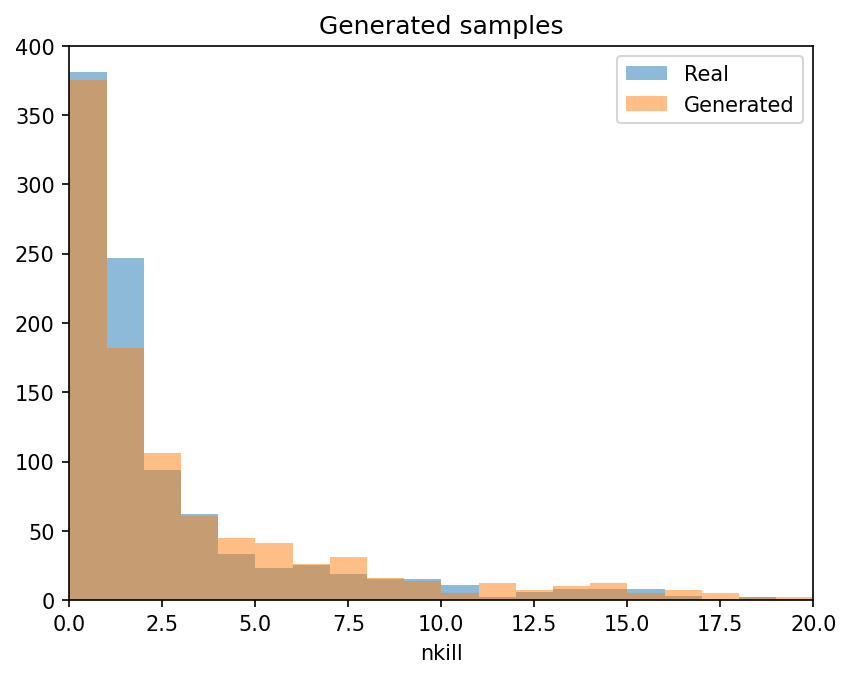

In [14]:
hist_compare(df2['nkill'], data)

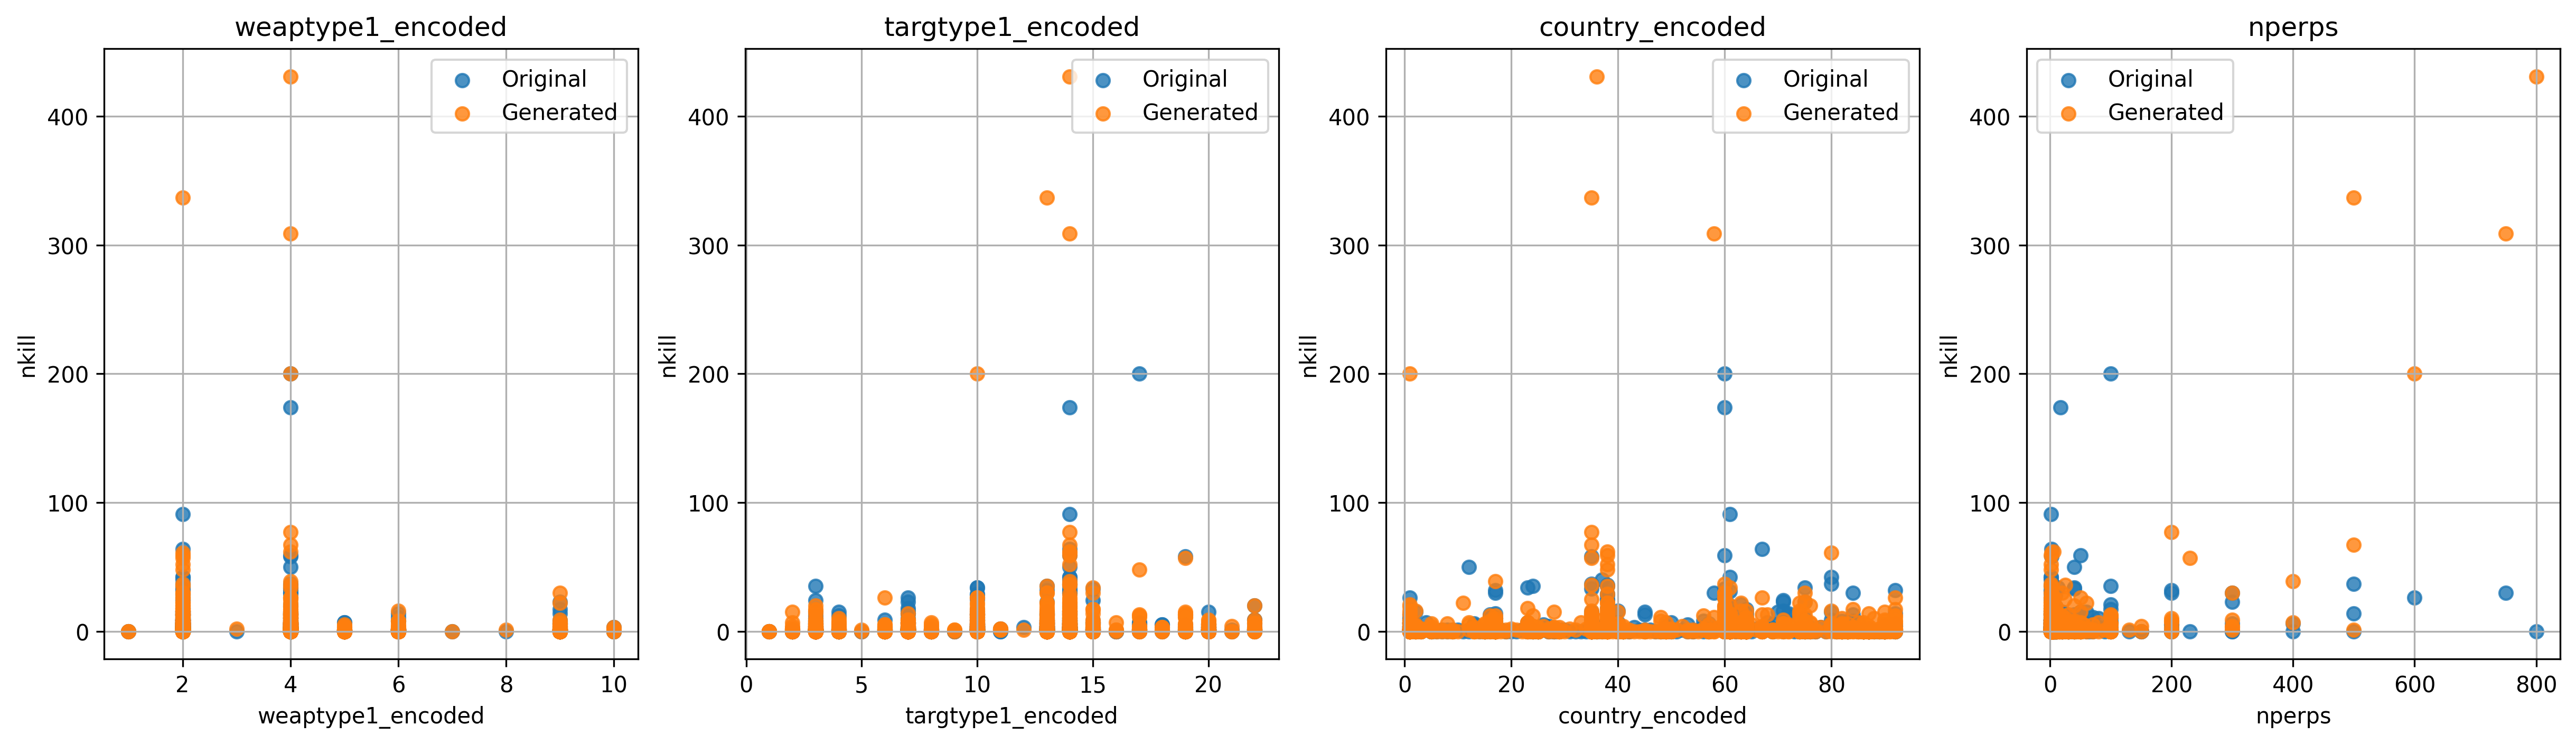

In [15]:
scatter_compare_display(df2[['weaptype1_encoded', 'targtype1_encoded', 'country_encoded', 'nperps']], df2["nkill"], data)

## 7. Model comparison

#### LOO Comparison

In [16]:
model1_info = az.from_cmdstanpy(sim1)
model2_info = az.from_cmdstanpy(sim2)

models_dict = {
    "model1": model1_info,
    "model2": model2_info,
}

loo_comparison = az.compare(models_dict, ic="loo", scale="negative_log")
display(loo_comparison)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more lik

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model2,0,2046.598977,63.466733,0.000000,0.978153,52.259560,0.000000,True,negative_log
model1,1,4242.432069,606.449894,2195.833092,0.021847,393.171584,359.155392,True,negative_log


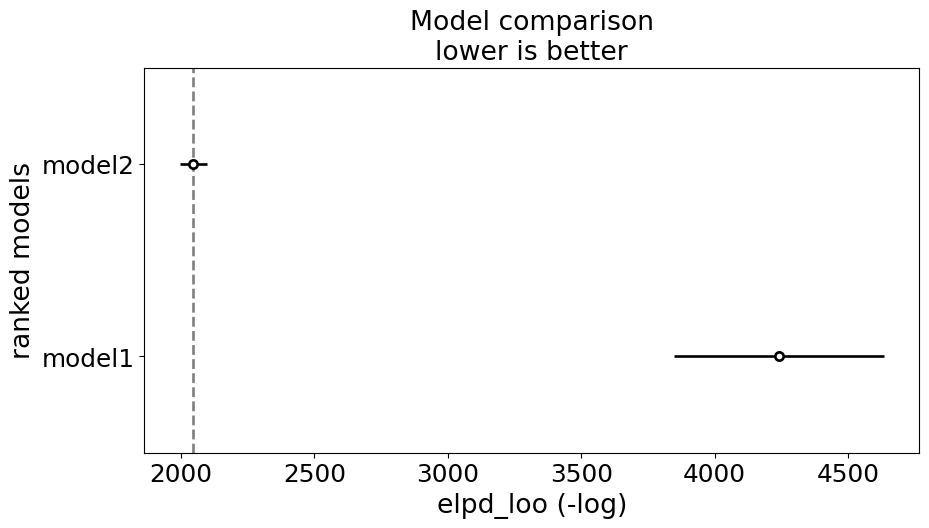

In [17]:
az.plot_compare(loo_comparison, figsize=(10, 5))
plt.show()

#### WAIC Comparison

In [18]:
waic_comparison = az.compare(models_dict, ic="waic", scale="negative_log")
display(waic_comparison)

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model2,0,2041.826709,58.694465,0.000000,0.972698,51.483483,0.000000,True,negative_log
model1,1,4333.419803,697.437629,2291.593095,0.027302,434.872681,402.548864,True,negative_log


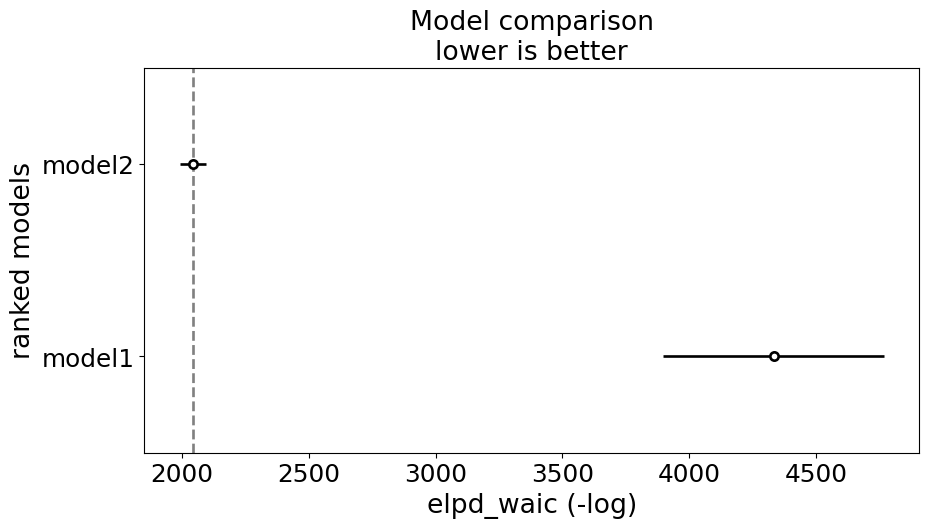

In [19]:
az.plot_compare(waic_comparison, figsize=(10, 5))
plt.show()